<a href="https://colab.research.google.com/github/Andresmup/Datahack-Fashion_MNIS/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANDRÉS MUÑOZ PAMPILLON - Identify the apparels (Fashion MNIST)**

## IMPORT

In [ ]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [ ]:
from torch import nn
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader


try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
import os
import requests
import zipfile
from pathlib import Path

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple, Dict, List
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from tqdm.auto import tqdm

## GET THE DATA

In [ ]:
#Function for folder content
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
# Setup path to data folder
data_path = Path("data/")

In [ ]:
label_path = data_path / "label"

# If the train folder doesn't exist, download it and prepare it...
if label_path.is_dir():
    print(f"{label_path} directory exists.")
else:
    print(f"Did not find {label_path} directory, creating one...")
    label_path.mkdir(parents=True, exist_ok=True)

    # Download train data
    with open(data_path / "label_fashion_mnist.zip", "wb") as f:
        request = requests.get("https://github.com/Andresmup/ArchivosDataScience/raw/main/train_fashion_mnist.zip")
        print("Downloading train fashion mnist data...")
        f.write(request.content)

    # Unzip
    with zipfile.ZipFile(data_path / "label_fashion_mnist.zip", "r") as zip_ref:
        print("Unzipping train fashion mnist data...")
        zip_ref.extractall(label_path)

Did not find data/label directory, creating one...
Unzipping train fashion mnist data...


In [ ]:
eval_path = data_path / "eval"

# If the eval folder doesn't exist, download it and prepare it...
if eval_path.is_dir():
    print(f"{eval_path} directory exists.")
else:
    print(f"Did not find {eval_path} directory, creating one...")
    eval_path.mkdir(parents=True, exist_ok=True)

    # Download eval data
    with open(data_path / "eval_fashion_mnist.zip", "wb") as f:
        request = requests.get("https://github.com/Andresmup/ArchivosDataScience/raw/main/test_fashion_mnist.zip")
        print("Downloading eval fashion mnist data...")
        f.write(request.content)

    # Unzip
    with zipfile.ZipFile(data_path / "eval_fashion_mnist.zip", "r") as zip_ref:
        print("Unzipping eval fashion mnist data...")
        zip_ref.extractall(eval_path)

Did not find data/eval directory, creating one...
Unzipping eval fashion mnist data...


In [ ]:
!mv data/label/train data/label/labels
!mv data/label/train.csv data/label/labels.csv
!mv data/eval/test data/eval/eval/
!mv data/eval/test.csv data/eval/eval.csv

## FIRST APPROACH

In [ ]:
#Check folder contents
walk_through_dir(data_path)

There are 2 directories and 2 images in 'data'.
There are 1 directories and 1 images in 'data/eval'.
There are 0 directories and 10000 images in 'data/eval/eval'.
There are 1 directories and 1 images in 'data/label'.
There are 0 directories and 60000 images in 'data/label/labels'.


In [ ]:
# Setup labels and evaling paths
labels_dir = label_path / "labels"
eval_dir = eval_path / "eval"

labels_dir, eval_dir

(PosixPath('data/label/labels'), PosixPath('data/eval/eval'))

Random image path: data/label/labels/59775.png
Image class: labels
Image height: 28
Image width: 28


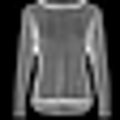

In [ ]:
# Set the random seed for reproducibility
random.seed(73) # <- change this

# Get a list of all .png image paths in the specified directory structure
image_path_list = list(data_path.glob("*/*/*.png"))

# Select a random image path from the list
random_image_path = random.choice(image_path_list)

# Extract the class of the selected image from its parent directory name
image_class = random_image_path.parent.stem

# Open the selected image using PIL
img = Image.open(random_image_path)

# Print the random image path, its class, and its dimensions
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

# Resize the image to (120, 120) pixels and display it
img.resize((120, 120))


In [ ]:
# Read the labels CSV file into a DataFrame
df_labels = pd.read_csv(f"{label_path}/labels.csv")

# Read the evaluation CSV file into a DataFrame
df_eval = pd.read_csv(f"{eval_path}/eval.csv")

# Display the DataFrames
df_labels, df_eval

(          id  label
 0          1      9
 1          2      0
 2          3      0
 3          4      3
 4          5      0
 ...      ...    ...
 59995  59996      5
 59996  59997      1
 59997  59998      3
 59998  59999      0
 59999  60000      5
 
 [60000 rows x 2 columns],
          id
 0     60001
 1     60002
 2     60003
 3     60004
 4     60005
 ...     ...
 9995  69996
 9996  69997
 9997  69998
 9998  69999
 9999  70000
 
 [10000 rows x 1 columns])

## PREPARATION CUSTOM DATASET

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, classes, transform=None):
        """
        Initialize the dataset with a DataFrame, image directory, class names, and optional transformations.
        Args:
            df (DataFrame): DataFrame containing image IDs and labels.
            img_dir (string): Directory with all the images.
            classes (list): List of class names.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = df  # Store the DataFrame with image IDs and labels
        self.img_dir = img_dir  # Store the directory containing the images
        self.transform = transform  # Store the optional transformations
        self.classes = classes  # Store the list of class names
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}  # Create a mapping from class names to indices

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.data_frame)

    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label) where image is the transformed image and label is the class label.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()  # Convert tensor index to list if necessary

        img_id = self.data_frame.iloc[idx, 0]  # Get the image ID from the DataFrame
        img_name = os.path.join(self.img_dir, f"{img_id}.png")  # Construct the full path to the image file
        image = Image.open(img_name)  # Open the image using PIL
        label = self.data_frame.iloc[idx, 1]  # Get the label from the DataFrame

        if self.transform:
            image = self.transform(image)  # Apply the transformations if specified

        return image, label  # Return the image and its label


In [ ]:
class_names = ['T-shirt/top','Trouser','Pullover', 'Dress','Coat','Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Define a transformation pipeline for training images
transform_train_prev = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to 28x28 pixels
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert the image to RGB mode
    v2.Grayscale(num_output_channels=1),  # Convert the image to grayscale with 1 output channel
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])


In [ ]:
# Create a custom dataset for training using the CustomImageDataset class
train_data_custom_prev = CustomImageDataset(
    df=df_labels,  # DataFrame containing image IDs and labels
    img_dir=labels_dir,  # Directory containing the images
    classes=class_names,  # List of class names
    transform=transform_train_prev  # Transformation pipeline to apply to the images
)


In [ ]:
def calculate_mean_std(dataset):
    """
    Calculate the mean and standard deviation of the images in a dataset.
    Args:
        dataset (Dataset): The dataset to calculate the statistics for.
    Returns:
        tuple: Mean and standard deviation of the dataset.
    """
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)  # Create a DataLoader with batch size of 1
    mean = 0.0  # Initialize mean to 0
    std = 0.0  # Initialize standard deviation to 0

    for images, _ in loader:  # Iterate over the DataLoader
        images = images.view(images.size(0), images.size(1), -1)  # Flatten the image
        mean += images.mean(2).sum(0)  # Sum the mean of the image along the third dimension
        std += images.std(2).sum(0)  # Sum the standard deviation of the image along the third dimension

    mean /= len(dataset)  # Calculate the mean over the entire dataset
    std /= len(dataset)  # Calculate the standard deviation over the entire dataset

    return mean.numpy(), std.numpy()  # Convert the mean and standard deviation to numpy arrays and return them


In [ ]:
# Calculate the mean and standard deviation of the training dataset
mean_train, std_train = calculate_mean_std(train_data_custom_prev)

# Print the calculated mean and standard deviation
print(f"Mean: {mean_train}, Std: {std_train}")


Mean: [0.28596714], Std: [0.32045418]


## CUSTOM DATASET FOR TRAIN AND TEST

In [ ]:
# Split the data into training and testing sets (80% training, 20% testing)
df_train, df_test = train_test_split(df_labels, test_size=0.2, random_state=42, stratify=df_labels['label'])

In [ ]:
# Define a transformation pipeline for training images
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to 28x28 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert the image to RGB mode
    v2.Grayscale(num_output_channels=1),  # Convert the image to grayscale with 1 output channel
    # v2.RandomRotation(degrees=(0, 180)),  # Optional: Randomly rotate the image between 0 and 180 degrees
    # v2.RandomInvert(),  # Optional: Randomly invert the colors of the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[mean_train[0]], std=[std_train[0]])  # Normalize the tensor with the calculated mean and standard deviation
])


In [ ]:
# Define a transformation pipeline for testing images
test_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to 28x28 pixels
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert the image to RGB mode
    v2.Grayscale(num_output_channels=1),  # Convert the image to grayscale with 1 output channel
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[mean_train[0]], std=[std_train[0]])  # Normalize the tensor with the calculated mean and standard deviation
])


In [ ]:
# Create a custom dataset for training using the CustomImageDataset class
train_data_custom = CustomImageDataset(
    df=df_train,  # DataFrame containing training image IDs and labels
    img_dir=labels_dir,  # Directory containing the images
    classes=class_names,  # List of class names
    transform=train_transform  # Transformation pipeline to apply to the images
)


In [ ]:
# Create a custom dataset for testing using the CustomImageDataset class
test_data_custom = CustomImageDataset(
    df=df_test,  # DataFrame containing test image IDs and labels
    img_dir=labels_dir,  # Directory containing the images
    classes=class_names,  # List of class names
    transform=test_transform  # Transformation pipeline to apply to the images during testing
)


In [ ]:
#Show class dict
train_data_custom.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

## DISPLAY TRAIN IMAGES

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    """
    Display random images from a dataset.

    Args:
        dataset (torch.utils.data.dataset.Dataset): Dataset containing images and labels.
        classes (List[str], optional): List of class names. Defaults to None.
        n (int, optional): Number of random images to display (max 10). Defaults to 10.
        display_shape (bool, optional): Whether to display the shape of each image. Defaults to True.
        seed (int, optional): Seed for random sampling. Defaults to None.
    """
    if n > 10:
        n = 10
        display_shape = False
        print(f"n max 10")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


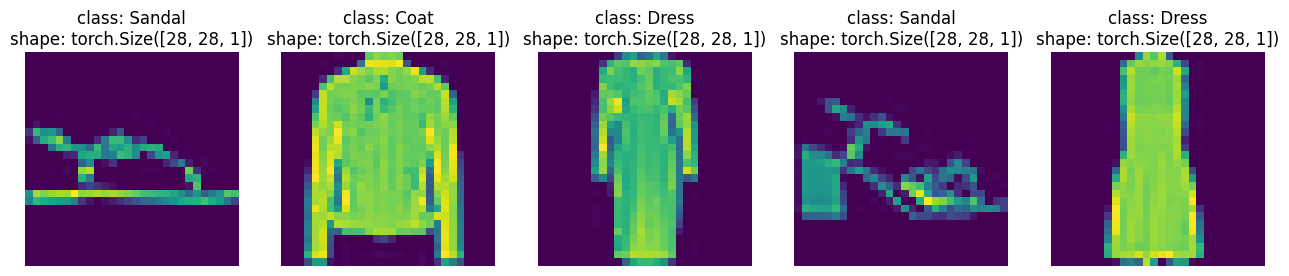

In [ ]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      display_shape=True,
                      seed=None)

## CREATE CUSTOM DATALOADER

In [ ]:
BATCH_SIZE = 32 #Define batch size

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data_custom,  # Using the CustomImageDataset instance for training data
    batch_size=BATCH_SIZE,  # Batch size for each iteration
    num_workers=0,  # Number of subprocesses to use for data loading (0 means data will be loaded in the main process)
    shuffle=True  # Shuffle the data at every epoch
)

train_dataloader

In [ ]:
img_custom, label_custom = next(iter(train_dataloader))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 1, 28, 28]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
test_dataloader = DataLoader(
    dataset=test_data_custom,  # CustomImageDataset instance for test data
    batch_size=BATCH_SIZE,  # Number of samples in each batch
    num_workers=0,  # Number of subprocesses to use for data loading (0 means data will be loaded in the main process)
    shuffle=True  # Whether to shuffle the data at every epoch
)

test_dataloader

In [ ]:
img_custom, label_custom = next(iter(test_dataloader))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 1, 28, 28]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## PYTORCH UTILITIES

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                class_names:List[str],
                model_save_name:str,
                optimizer=None,
                NUM_EPOCHS=5,
                BATCH_SIZE=32,
                LEARNING_RATE=0.001):

    # Set random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Setup target device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Set loss and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optimizer or torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Start the timer
    start_time = timer()

    # Train model
    results = train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
        device=device
    )

    # End the timer and print out how long it took
    end_time = timer()
    execution_time = end_time - start_time
    print(f"[INFO] Total training time: {execution_time:.3f} seconds")

    # Save the model
    save_model(
        model=model,
        target_dir="models",
        model_name=model_save_name
    )
    return results, execution_time

In [ ]:
def plot_loss_curves(results):
  """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
  """
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

## SETUP GPU

In [ ]:
#Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## EFFICIENTNET_B1

In [ ]:
# Import necessary libraries and modules
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Define a custom method to retrieve state dictionary without checking hash
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")  # Remove the 'check_hash' argument from kwargs
    return load_state_dict_from_url(self.url, *args, **kwargs)

# Attach the custom method to WeightsEnum class
WeightsEnum.get_state_dict = get_state_dict

# Example of loading the EfficientNet-B1 model with default weights
efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)

# Another way to load the EfficientNet-B1 model with default weights
efficientnet_b1(weights="DEFAULT")

# Specify the weights to use for EfficientNet-B1
weights_efficientnet_b1 = torchvision.models.EfficientNet_B1_Weights.DEFAULT  # .DEFAULT = best available weights

# Instantiate the EfficientNet-B1 model with the specified weights and move it to the device (e.g., GPU)
model_efficientnet_b1 = torchvision.models.efficientnet_b1(weights=weights_efficientnet_b1).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 153MB/s]


In [ ]:
# Modify first convolutional layer to accept color channel 1
model_efficientnet_b1.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False

#for param in model_efficientnet_b1.features.parameters():
#    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_efficientnet_b1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_efficientnet_b1,
        input_size=(32, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 1, 28, 28]      [32, 10]             --                   True
├─Sequential (features)                                      [32, 1, 28, 28]      [32, 1280, 1, 1]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 1, 28, 28]      [32, 32, 14, 14]     --                   True
│    │    └─Conv2d (0)                                       [32, 1, 28, 28]      [32, 32, 14, 14]     288                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 14, 14]     [32, 32, 14, 14]     64                   True
│    │    └─SiLU (2)                                         [32, 32, 14, 14]     [32, 32, 14, 14]     --                   --
│    └─Sequential (1)                                        [32, 32, 14, 14]     [32, 16, 14,

## TRAIN EFFICIENTNET_B1

In [ ]:
#Training
results_efficientnet_b1, time_efficientnet_b1 = train_model(
    model=model_efficientnet_b1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_names=class_names,
    model_save_name="model_efficientnet_b1.pth",
    optimizer=torch.optim.Adam(model_efficientnet_b1.parameters(),lr=0.001),
    NUM_EPOCHS=10,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7077 | train_acc: 0.7489 | test_loss: 0.4047 | test_acc: 0.8563
Epoch: 2 | train_loss: 0.4473 | train_acc: 0.8418 | test_loss: 0.3411 | test_acc: 0.8787
Epoch: 3 | train_loss: 0.3719 | train_acc: 0.8666 | test_loss: 0.2914 | test_acc: 0.8998
Epoch: 4 | train_loss: 0.3320 | train_acc: 0.8838 | test_loss: 0.3041 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.3121 | train_acc: 0.8887 | test_loss: 0.2516 | test_acc: 0.9122
Epoch: 6 | train_loss: 0.2847 | train_acc: 0.8983 | test_loss: 0.2762 | test_acc: 0.9012
Epoch: 7 | train_loss: 0.2649 | train_acc: 0.9060 | test_loss: 0.2620 | test_acc: 0.9040
Epoch: 8 | train_loss: 0.2481 | train_acc: 0.9115 | test_loss: 0.2495 | test_acc: 0.9111
Epoch: 9 | train_loss: 0.2390 | train_acc: 0.9139 | test_loss: 0.2437 | test_acc: 0.9157
Epoch: 10 | train_loss: 0.2343 | train_acc: 0.9175 | test_loss: 0.2449 | test_acc: 0.9121
[INFO] Total training time: 1250.977 seconds
[INFO] Saving model to: models/model_efficientnet_b1.pth


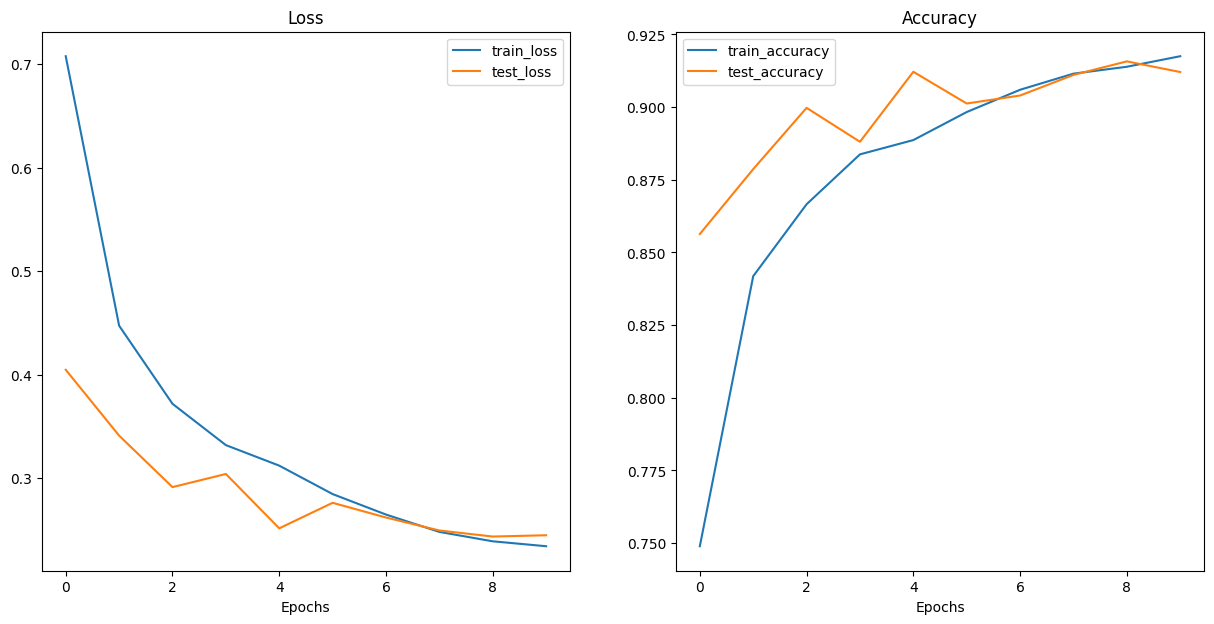

In [ ]:
# Plot the loss curves of our model
plot_loss_curves(results_efficientnet_b1)

## RESNET 50

In [ ]:
# Import necessary libraries and modules
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Define a custom method to retrieve state dictionary without checking hash
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")  # Remove the 'check_hash' argument from kwargs
    return load_state_dict_from_url(self.url, *args, **kwargs)

# Attach the custom method to WeightsEnum class
WeightsEnum.get_state_dict = get_state_dict

# Example of loading the ResNet-50 model with default weights
resnet50(weights=ResNet50_Weights.DEFAULT)

# Another way to load the ResNet-50 model with default weights
resnet50(weights="DEFAULT")

# Specify the weights to use for ResNet-50
weights_resnet_50 = torchvision.models.ResNet50_Weights.DEFAULT  # .DEFAULT = best available weights

# Instantiate the ResNet-50 model with the specified weights and move it to the device (e.g., GPU)
model_resnet_50 = torchvision.models.resnet50(weights=weights_resnet_50).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.4MB/s]


In [ ]:
# Modify first convolutional layer to accept color channel 1
model_resnet_50.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
#Setting trainable to false
#for name, param in model_resnet_50.named_parameters():
#    if not name.startswith('Linear'):  # Exclude parameters of the classifier layer
#        param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)


# Recreate the classifier layer and seed it to the target device
model_resnet_50.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2048,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_resnet_50,
        input_size=(32, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 1, 28, 28]      [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 1, 28, 28]      [32, 64, 14, 14]     3,136                True
├─BatchNorm2d (bn1)                      [32, 64, 14, 14]     [32, 64, 14, 14]     128                  True
├─ReLU (relu)                            [32, 64, 14, 14]     [32, 64, 14, 14]     --                   --
├─MaxPool2d (maxpool)                    [32, 64, 14, 14]     [32, 64, 7, 7]       --                   --
├─Sequential (layer1)                    [32, 64, 7, 7]       [32, 256, 7, 7]      --                   True
│    └─Bottleneck (0)                    [32, 64, 7, 7]       [32, 256, 7, 7]      --                   True
│    │    └─Conv2d (conv1)               [32, 64, 7, 7]       [32, 64, 7, 7]       4,096                True
│    │    └─BatchN

## TRAIN RESNET 50

In [ ]:
#Training
results_resnet_50, time_resnet_50 = train_model(
    model=model_resnet_50,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_names=class_names,
    model_save_name="model_resnet_50.pth",
    optimizer=torch.optim.Adam(model_resnet_50.parameters(),lr=0.001),
    NUM_EPOCHS=10,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6632 | train_acc: 0.7721 | test_loss: 0.4412 | test_acc: 0.8451
Epoch: 2 | train_loss: 0.4376 | train_acc: 0.8488 | test_loss: 0.3536 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.3913 | train_acc: 0.8638 | test_loss: 0.3091 | test_acc: 0.8878
Epoch: 4 | train_loss: 0.3612 | train_acc: 0.8761 | test_loss: 0.3481 | test_acc: 0.8768
Epoch: 5 | train_loss: 0.3303 | train_acc: 0.8826 | test_loss: 0.2743 | test_acc: 0.9001
Epoch: 6 | train_loss: 0.3338 | train_acc: 0.8845 | test_loss: 0.2808 | test_acc: 0.9008
Epoch: 7 | train_loss: 0.3189 | train_acc: 0.8914 | test_loss: 0.2799 | test_acc: 0.9045
Epoch: 8 | train_loss: 0.2711 | train_acc: 0.9040 | test_loss: 0.2631 | test_acc: 0.9056
Epoch: 9 | train_loss: 0.3348 | train_acc: 0.8931 | test_loss: 0.2657 | test_acc: 0.9042
Epoch: 10 | train_loss: 0.2904 | train_acc: 0.9013 | test_loss: 0.2443 | test_acc: 0.9127
[INFO] Total training time: 969.107 seconds
[INFO] Saving model to: models/model_resnet_50.pth


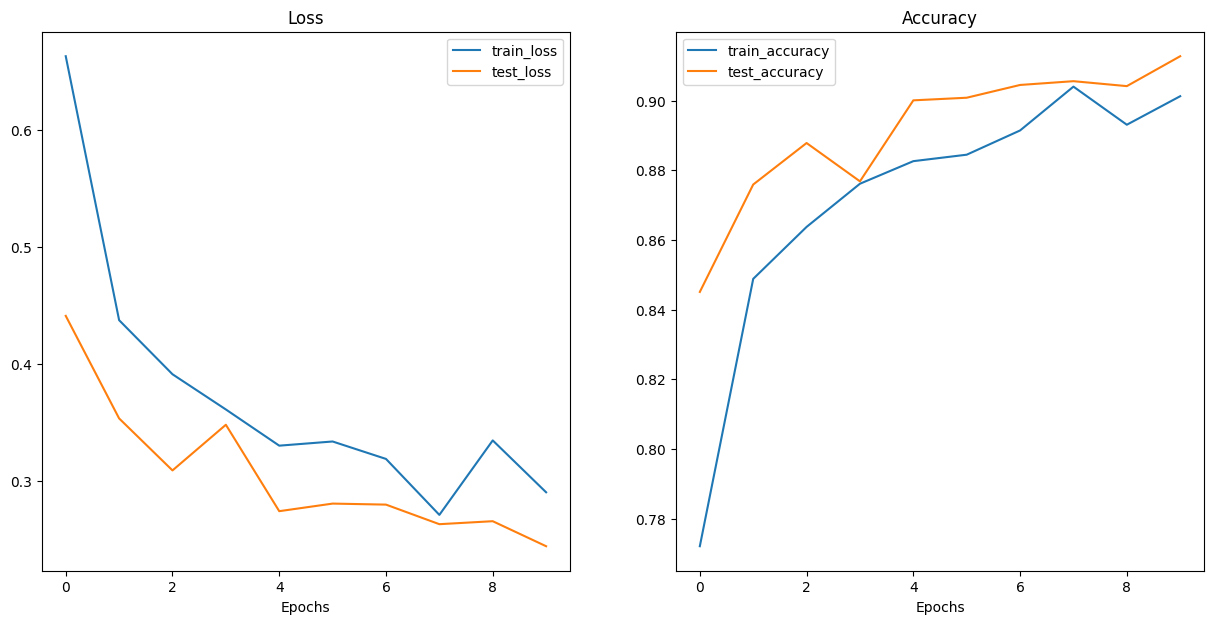

In [ ]:
# Plot the loss curves of our model
plot_loss_curves(results_resnet_50)

## RESNET 101

In [ ]:
# Import necessary libraries and modules
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# Define a custom method to retrieve state dictionary without checking hash
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")  # Remove the 'check_hash' argument from kwargs
    return load_state_dict_from_url(self.url, *args, **kwargs)

# Attach the custom method to WeightsEnum class
WeightsEnum.get_state_dict = get_state_dict

# Example of loading the ResNet-101 model with default weights
resnet101(weights=ResNet101_Weights.DEFAULT)

# Another way to load the ResNet-101 model with default weights
resnet101(weights="DEFAULT")

# Specify the weights to use for ResNet-101
weights_resnet_101 = torchvision.models.ResNet101_Weights.DEFAULT  # .DEFAULT = best available weights

# Instantiate the ResNet-101 model with the specified weights and move it to the device (e.g., GPU)
model_resnet_101 = torchvision.models.resnet101(weights=weights_resnet_101).to(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:05<00:00, 35.4MB/s]


In [ ]:
# Modify first convolutional layer to accept color channel 1
model_resnet_101.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)


# Recreate the classifier layer and seed it to the target device
model_resnet_101.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2048,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)


In [ ]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_resnet_101,
        input_size=(32, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 1, 28, 28]      [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 1, 28, 28]      [32, 64, 14, 14]     3,136                True
├─BatchNorm2d (bn1)                      [32, 64, 14, 14]     [32, 64, 14, 14]     128                  True
├─ReLU (relu)                            [32, 64, 14, 14]     [32, 64, 14, 14]     --                   --
├─MaxPool2d (maxpool)                    [32, 64, 14, 14]     [32, 64, 7, 7]       --                   --
├─Sequential (layer1)                    [32, 64, 7, 7]       [32, 256, 7, 7]      --                   True
│    └─Bottleneck (0)                    [32, 64, 7, 7]       [32, 256, 7, 7]      --                   True
│    │    └─Conv2d (conv1)               [32, 64, 7, 7]       [32, 64, 7, 7]       4,096                True
│    │    └─BatchN

## TRAIN RESNET 101

In [ ]:
#Training
results_resnet_101, time_resnet_101 = train_model(
    model=model_resnet_101,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    class_names=class_names,
    model_save_name="model_resnet_101.pth",
    optimizer=torch.optim.Adam(model_resnet_101.parameters(),lr=0.001),
    NUM_EPOCHS=10,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6792 | train_acc: 0.7731 | test_loss: 0.4214 | test_acc: 0.8505
Epoch: 2 | train_loss: 0.4582 | train_acc: 0.8427 | test_loss: 0.3747 | test_acc: 0.8648
Epoch: 3 | train_loss: 0.4077 | train_acc: 0.8578 | test_loss: 0.3339 | test_acc: 0.8703
Epoch: 4 | train_loss: 0.3585 | train_acc: 0.8764 | test_loss: 0.3468 | test_acc: 0.8711
Epoch: 5 | train_loss: 0.3586 | train_acc: 0.8777 | test_loss: 0.2754 | test_acc: 0.9004
Epoch: 6 | train_loss: 0.3456 | train_acc: 0.8811 | test_loss: 0.2852 | test_acc: 0.8983
Epoch: 7 | train_loss: 0.3449 | train_acc: 0.8841 | test_loss: 0.2651 | test_acc: 0.9051
Epoch: 8 | train_loss: 0.2806 | train_acc: 0.9005 | test_loss: 0.2651 | test_acc: 0.9064
Epoch: 9 | train_loss: 0.2980 | train_acc: 0.8976 | test_loss: 0.5803 | test_acc: 0.8853
Epoch: 10 | train_loss: 0.2822 | train_acc: 0.9026 | test_loss: 0.2739 | test_acc: 0.9009
[INFO] Total training time: 1393.351 seconds
[INFO] Saving model to: models/model_resnet_101.pth


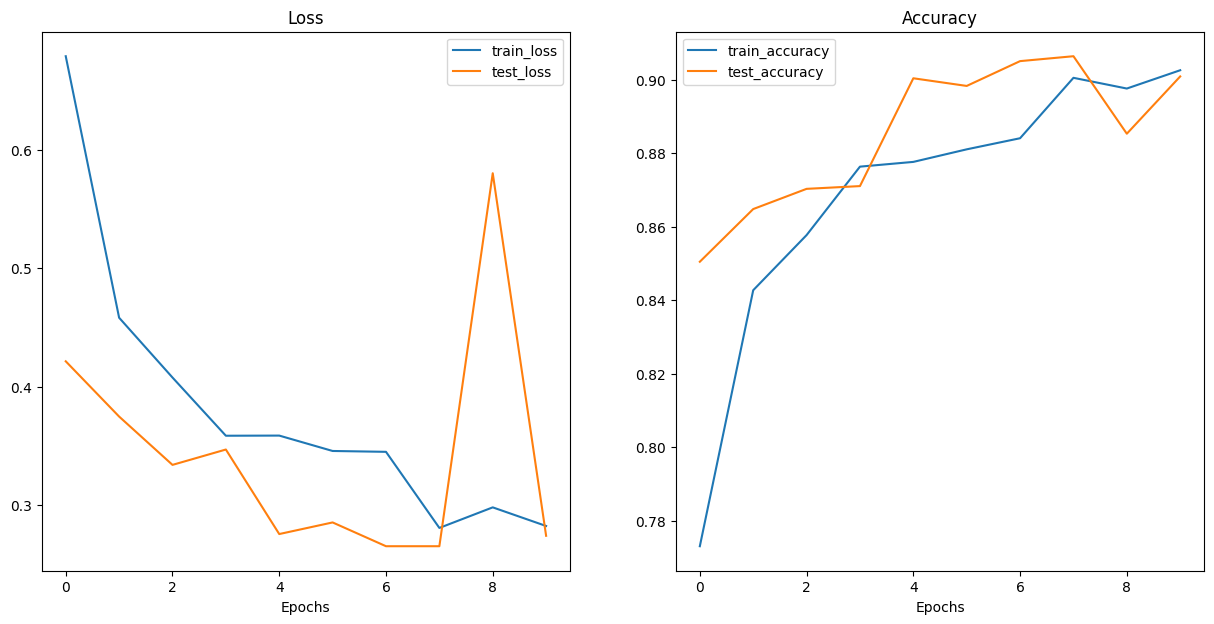

In [ ]:
# Plot the loss curves of our model
plot_loss_curves(results_resnet_101)

## MAKE PREDICTIONS

Using the Efficientnet_b1 model we are going to make the predictions.

In [ ]:
df_eval

,id
0,60001
1,60002
2,60003
3,60004
4,60005
...,...
9995,69996
9996,69997
9997,69998
9998,69999


In [ ]:
#Load model (if the evaluation is done by uploading the pth file instead of train directly)
model_path = "models/model_efficientnet_b1.pth"
state_dict = torch.load(model_path)

#The model was save as state dict
model_efficientnet_b1.load_state_dict(state_dict)

model_efficientnet_b1.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
#Function to process the raw images in the eval folder
def load_and_process_image(image_path, transform):

    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image

In [ ]:
# Use GPU when its posible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_efficientnet_b1 = model_efficientnet_b1.to(device)

#Tranform for eval images
eval_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to 28x28 pixels
    transforms.Lambda(lambda img: img.convert("RGB")),  # Convert the image to RGB mode
    v2.Grayscale(num_output_channels=1),  # Convert the image to grayscale with 1 output channel
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[mean_train[0]], std=[std_train[0]])  # Normalize the tensor with the calculated mean and standard deviation
])

# Loop through eval folder to make a prediction and save the result in the df_eval dataframe
for index, row in df_eval.iterrows():
    # Build each image path
    image_path = str(eval_dir / (str(row['id']) + '.png'))

    # Load and process image
    image = load_and_process_image(image_path, eval_transform)
    image = image.unsqueeze(0).to(device)

    # Make the prediction
    with torch.no_grad():
        outputs = model_efficientnet_b1(image)
        _, predicted = torch.max(outputs, 1)

    # Get prediction label
    predicted_label = predicted.item()

    # Add prediction label to dataframe
    df_eval.at[index, 'label'] = predicted_label

# Check dataframe
print(df_eval.head())

      id  label
0  60001    9.0
1  60002    2.0
2  60003    1.0
3  60004    1.0
4  60005    6.0


In [ ]:
#Change label values format because the solution must be an integer type
df_eval["label"] = pd.to_numeric(df_eval["label"], downcast='integer')

df_eval

,id,label
0,60001,9
1,60002,2
2,60003,1
3,60004,1
4,60005,6
...,...,...
9995,69996,9
9996,69997,1
9997,69998,8
9998,69999,1


In [ ]:
#Save dataframe as csv file
df_eval.to_csv("submission.csv", index=False)